In [2]:
# Import required packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from skimage.io import imread
from skimage.transform import resize
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import random
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn as nn
import torch.nn.init as init

2024-11-26 15:03:16.971922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import image data, including flattening the images and converting them to an array
    # (Without masks)
#normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
#covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
#images = []
#labels = []
#for image in os.listdir(normal_folder_path):
#    image_path = os.path.join(normal_folder_path, image)
#    i = mpimg.imread(image_path)
#    #i = resize(i, (299,299))
#    flati = i.flatten()
#    images.append(flati)
#    labels.append(0)
#for image in os.listdir(covid_folder_path):
#    image_path = os.path.join(covid_folder_path, image)
#    i = mpimg.imread(image_path)
#    #i = resize(i, (299,299))
#    flati = i.flatten()
#    images.append(flati)
#    labels.append(1)
#X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [4]:
# Import image data, including flattening the images and converting them to an array
    # (With masks)
normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
normal_mask_path = 'COVID-19_Radiography_Dataset/Normal/masks'
covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
covid_mask_path = 'COVID-19_Radiography_Dataset/COVID/masks'
images = []
labels = []
for image in os.listdir(normal_folder_path):
    image_path = os.path.join(normal_folder_path, image)
    mask_path = os.path.join(normal_mask_path, image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(0)
for image in os.listdir(covid_folder_path):
    image_path = os.path.join(covid_folder_path, image)
    mask_path = os.path.join(covid_mask_path,image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(1)
X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [5]:
# Split the data into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2024) # test set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.18, random_state=2024) # validation set

In [6]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [7]:
# Create PCA sets for reduced dimension models
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [8]:
# Convert to tensors for PyTorch training
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)
X_val_scaled_tensor = torch.tensor(X_val_scaled, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val ,dtype = torch.float32)

X_train_tensor_pca = torch.tensor(X_train_pca, dtype = torch.float32)
X_test_tensor_pca = torch.tensor(X_test_pca, dtype = torch.float32)
X_val_tensor_pca = torch.tensor(X_val_pca, dtype = torch.float32)

In [59]:
# Define a direct MLP model
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class DirectMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 512),
            nn.ReLU(),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class DropoutMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class PCA_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 10),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class PCA_ExtraParam_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)   

In [10]:
# Create function to test each model
def test_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # Forward pass: compute predictions
            outputs = model(inputs)
            
            # Since our output is a single probability (binary classification), 
            # apply threshold to classify
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            
            # Collect predictions and labels for F1-score
            all_labels.extend(labels.cpu().numpy())  # Convert to numpy for compatibility
            all_predictions.extend(predicted.cpu().numpy())
            
            # Update totals
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct / total
    
    # Calculate precision, recall, and F1
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    return accuracy, precision, recall, f1

In [57]:
test_dataset = TensorDataset(X_test_scaled_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

**Train Logistic Regression Model**

In [14]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
LR_model = LogisticRegression()
optimizer = torch.optim.Adam(LR_model.parameters(), lr=0.001)
num_epochs = 500

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    LR_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = LR_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    LR_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = LR_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/500], Train Loss: 4.4566, Val Loss: 4.2529
Epoch [2/500], Train Loss: 3.6348, Val Loss: 3.4261
Epoch [3/500], Train Loss: 3.4026, Val Loss: 4.1251
Patience Counter: 1/50
Epoch [4/500], Train Loss: 3.0787, Val Loss: 4.7584
Patience Counter: 2/50
Epoch [5/500], Train Loss: 2.7243, Val Loss: 4.9910
Patience Counter: 3/50
Epoch [6/500], Train Loss: 2.5907, Val Loss: 4.2849
Patience Counter: 4/50
Epoch [7/500], Train Loss: 2.6402, Val Loss: 4.3240
Patience Counter: 5/50
Epoch [8/500], Train Loss: 2.3736, Val Loss: 5.0695
Patience Counter: 6/50
Epoch [9/500], Train Loss: 2.3746, Val Loss: 4.4526
Patience Counter: 7/50
Epoch [10/500], Train Loss: 2.0225, Val Loss: 4.4434
Patience Counter: 8/50
Epoch [11/500], Train Loss: 1.8967, Val Loss: 5.2301
Patience Counter: 9/50
Epoch [12/500], Train Loss: 1.9458, Val Loss: 4.6931
Patience Counter: 10/50
Epoch [13/500], Train Loss: 1.7445, Val Loss: 4.4858
Patience Counter: 11/50
Epoch [14/500], Train Loss: 1.7733, Val Loss: 5.2493
Patience Cou

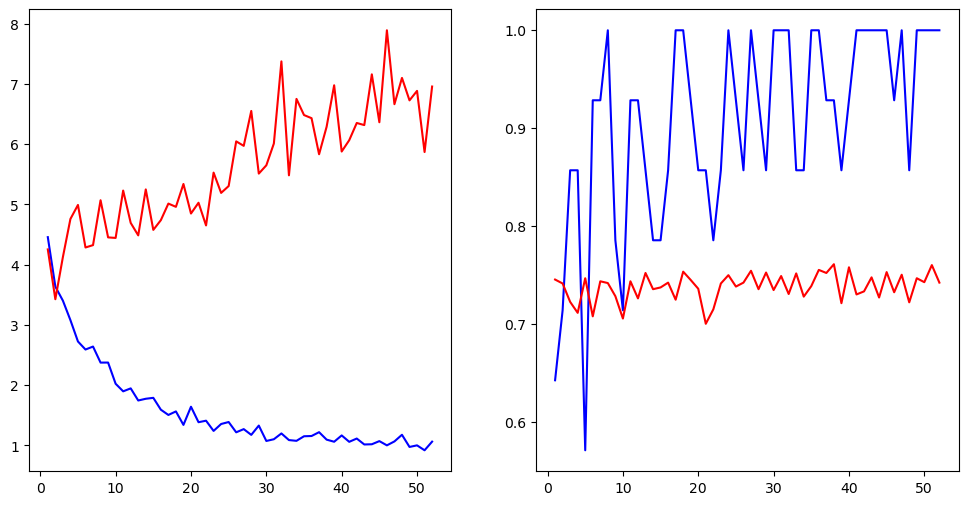

In [15]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [16]:
LR_train_evaluation = test_model(LR_model,train_dataloader)
LR_val_evaluation = test_model(LR_model,val_dataloader)
LR_test_evaluation = test_model(LR_model,test_dataloader)
LR_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": LR_train_evaluation,
    "Validation": LR_val_evaluation,
    "Test": LR_test_evaluation,
}
LR_evaluation = pd.DataFrame(LR_evaluation)
LR_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.953484,0.742512,0.740768
1,Precision,0.914726,0.510204,0.483333
2,Recall,0.907905,0.510204,0.502890
3,F1-Score,0.911302,0.510204,0.492918


**Train MLP Model**

In [17]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Early stopping parameters
patience = 3  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
MLP_model = DirectMLP()
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
num_epochs = 80

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    MLP_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = MLP_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    MLP_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = MLP_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/80], Train Loss: 7.4552, Val Loss: 3.2265
Epoch [2/80], Train Loss: 1.9515, Val Loss: 2.3236
Epoch [3/80], Train Loss: 1.5300, Val Loss: 1.2859
Epoch [4/80], Train Loss: 0.8569, Val Loss: 1.3808
Patience Counter: 1/5
Epoch [5/80], Train Loss: 0.7512, Val Loss: 1.2994
Patience Counter: 2/5
Epoch [6/80], Train Loss: 0.7138, Val Loss: 1.4331
Patience Counter: 3/5
Epoch [7/80], Train Loss: 0.7103, Val Loss: 1.5140
Patience Counter: 4/5
Epoch [8/80], Train Loss: 0.5992, Val Loss: 1.7437
Patience Counter: 5/5
Early stopping triggered!


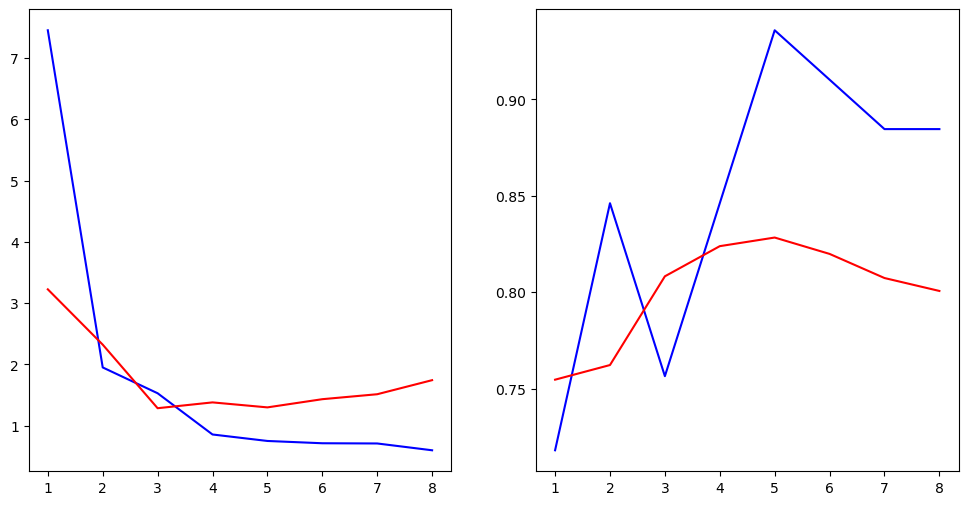

In [20]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [21]:
MLP_train_evaluation = test_model(MLP_model,train_dataloader)
MLP_val_evaluation = test_model(MLP_model,val_dataloader)
MLP_test_evaluation = test_model(MLP_model,test_dataloader)
MLP_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": MLP_train_evaluation,
    "Validation": MLP_val_evaluation,
    "Test": MLP_test_evaluation,
}
MLP_evaluation = pd.DataFrame(MLP_evaluation)
MLP_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.922669,0.800626,0.812455
1,Precision,0.793734,0.602305,0.604317
2,Recall,0.954139,0.710884,0.728324
3,F1-Score,0.866576,0.652106,0.660550


**Train Dropout Model**

In [54]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
Dropout_model = DropoutMLP()
optimizer = torch.optim.Adam(Dropout_model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    Dropout_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = Dropout_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    Dropout_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = Dropout_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/50], Train Loss: 0.7989, Val Loss: 0.4823
Epoch [2/50], Train Loss: 0.5060, Val Loss: 0.4691
Epoch [3/50], Train Loss: 0.4884, Val Loss: 0.4545
Epoch [4/50], Train Loss: 0.4685, Val Loss: 0.4483
Epoch [5/50], Train Loss: 0.4651, Val Loss: 0.5322
Patience Counter: 1/2
Epoch [6/50], Train Loss: 0.4713, Val Loss: 0.4679
Patience Counter: 2/2
Early stopping triggered!


Text(0.5, 1.0, 'Training and Validation Accuracy')

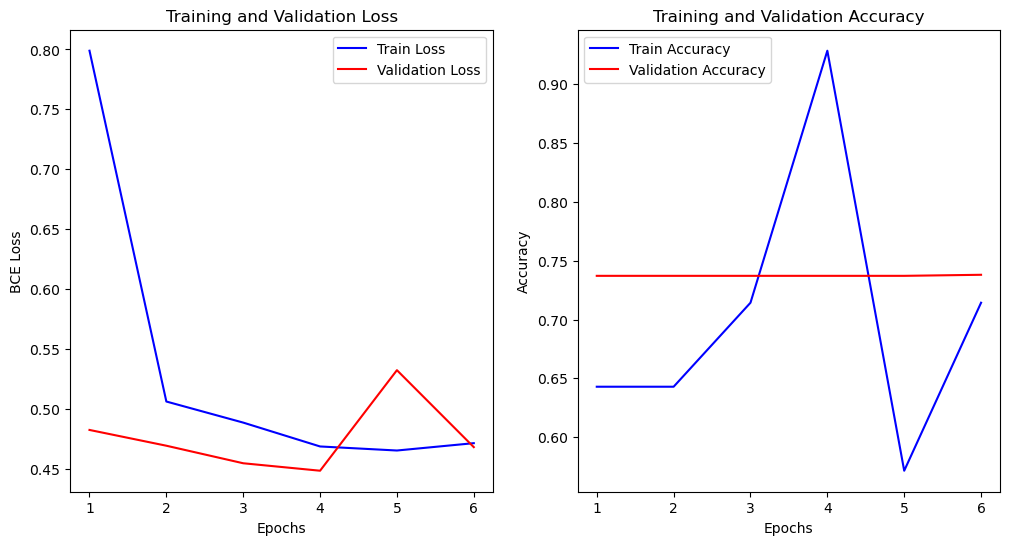

In [60]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [58]:
Dropout_train_evaluation = test_model(Dropout_model,train_dataloader)
Dropout_val_evaluation = test_model(Dropout_model,val_dataloader)
Dropout_test_evaluation = test_model(Dropout_model,test_dataloader)
Dropout_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": Dropout_train_evaluation,
    "Validation": Dropout_val_evaluation,
    "Test": Dropout_test_evaluation,
}
Dropout_evaluation = pd.DataFrame(Dropout_evaluation)
Dropout_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.737488,0.738042,0.750181
1,Precision,1.000000,1.000000,1.000000
2,Recall,0.002610,0.003401,0.002890
3,F1-Score,0.005206,0.006780,0.005764


**Train PCA Reduced Model**

In [48]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Early stopping parameters
patience = 2  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
PCA_model = PCA_MLP()
optimizer = torch.optim.Adam(PCA_model.parameters(), lr=0.001)
num_epochs = 150

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    PCA_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = PCA_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    PCA_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = PCA_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/150], Train Loss: 0.4913, Val Loss: 0.4518
Epoch [2/150], Train Loss: 0.3988, Val Loss: 0.4356
Epoch [3/150], Train Loss: 0.3439, Val Loss: 0.4533
Patience Counter: 1/2
Epoch [4/150], Train Loss: 0.3019, Val Loss: 0.5360
Patience Counter: 2/2
Early stopping triggered!


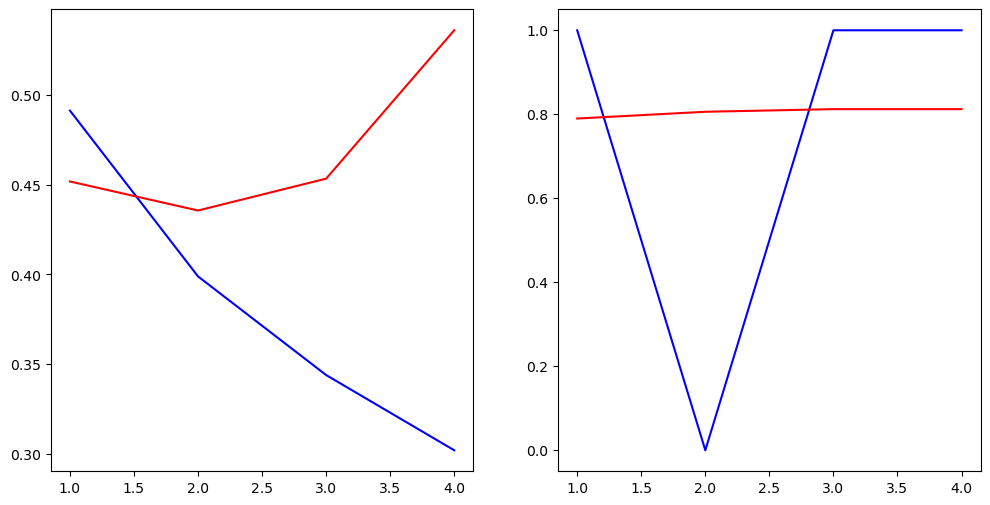

In [49]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [50]:
test_dataset = TensorDataset(X_test_tensor_pca, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

In [51]:
PCA_train_evaluation = test_model(PCA_model,train_dataloader)
PCA_val_evaluation = test_model(PCA_model,val_dataloader)
PCA_test_evaluation = test_model(PCA_model,test_dataloader)
PCA_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": PCA_train_evaluation,
    "Validation": PCA_val_evaluation,
    "Test": PCA_test_evaluation,
}
PCA_evaluation = pd.DataFrame(PCA_evaluation)
PCA_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.905496,0.812249,0.821868
1,Precision,0.915820,0.690909,0.701613
2,Recall,0.705817,0.517007,0.502890
3,F1-Score,0.797220,0.591440,0.585859


**Train PCA Model with Extra Parameters**

In [41]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early stopping parameters
patience = 8  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
PCAX_model = PCA_ExtraParam_MLP()
optimizer = torch.optim.Adam(PCAX_model.parameters(), lr=0.001)
num_epochs = 75

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    PCAX_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = PCAX_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    PCAX_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = PCAX_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/75], Train Loss: 0.4445, Val Loss: 0.4062
Epoch [2/75], Train Loss: 0.3169, Val Loss: 0.3960
Epoch [3/75], Train Loss: 0.2346, Val Loss: 0.4439
Patience Counter: 1/8
Epoch [4/75], Train Loss: 0.1673, Val Loss: 0.5798
Patience Counter: 2/8
Epoch [5/75], Train Loss: 0.1267, Val Loss: 0.7056
Patience Counter: 3/8
Epoch [6/75], Train Loss: 0.0896, Val Loss: 0.7594
Patience Counter: 4/8
Epoch [7/75], Train Loss: 0.0673, Val Loss: 0.9649
Patience Counter: 5/8
Epoch [8/75], Train Loss: 0.0471, Val Loss: 1.0129
Patience Counter: 6/8
Epoch [9/75], Train Loss: 0.0407, Val Loss: 1.0752
Patience Counter: 7/8
Epoch [10/75], Train Loss: 0.0400, Val Loss: 0.9953
Patience Counter: 8/8
Early stopping triggered!


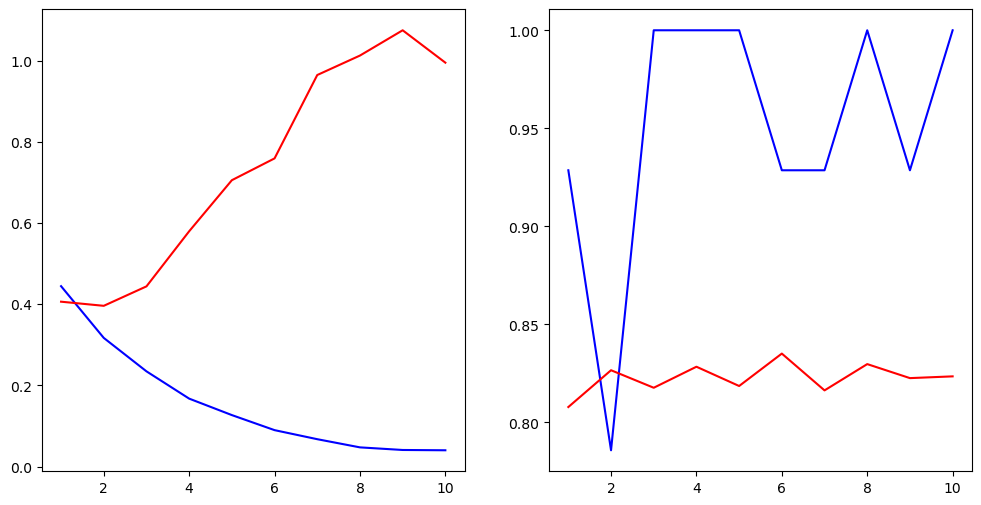

In [42]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [43]:
PCAX_train_evaluation = test_model(PCA_model,train_dataloader)
PCAX_val_evaluation = test_model(PCA_model,val_dataloader)
PCAX_test_evaluation = test_model(PCA_model,test_dataloader)
PCAX_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": PCAX_train_evaluation,
    "Validation": PCAX_val_evaluation,
    "Test": PCAX_test_evaluation,
}
PCAX_evaluation = pd.DataFrame(PCAX_evaluation)
PCAX_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.919921,0.816272,0.811731
1,Precision,0.851810,0.657194,0.631902
2,Recall,0.842282,0.629252,0.595376
3,F1-Score,0.847019,0.642919,0.613095
